# Playground

The goal of this project is to generate medical reports from X-ray images. The images are in grayscale. We will work on a few so-called *image2text* models.

In [28]:
# @TODO: extract tags
# @TODO: script-ify code
# @TODO: where did "." go in the generated reports?

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [30]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza
stanza.download("en")

from utils import *
from dataset import *
from plots import *
from models import *

fix_seed()

09:53:10 - INFO: Downloading default packages for language: en (English) ...
09:53:11 - INFO: File exists: /home/rasmus/stanza_resources/en/default.zip
09:53:16 - INFO: Finished downloading models and saved to /home/rasmus/stanza_resources.


## Load data

Let's load the metadata and the images.

In [4]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [5]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

09:48:20 - INFO: found 3955 reports.


,image_name,comparison,indication,findings,impression
count,7470,6313,7311,6473,7418
unique,7470,394,2454,2553,1770
top,CXR82_IM-2350-3001.png,None.,Chest pain,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,1,1592,253,98,586


Notice, some of the text is censored by replacing words with "XXXX".

In [6]:
metadata.head()

,image_name,comparison,indication,findings,impression
0,CXR82_IM-2350-3001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
1,CXR82_IM-2350-4001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
2,CXR173_IM-0481-1001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
3,CXR173_IM-0481-2001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
4,CXR3676_IM-1829-0001-0001.png,Comparison is XXXX to XXXX examination dated X...,XXXX-year-old male with XXXX.,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [7]:
reports = prepare_reports(metadata)
reports.head()
#pd.merge(metadata, report, left_index=True, right_index=True)

raw report length: 7470
post-processing report length: 7430


0    No airspace disease, effusion or noncalcified ...
1    No airspace disease, effusion or noncalcified ...
2    Low lung volumes. Cardiomediastinal silhouette...
3    Low lung volumes. Cardiomediastinal silhouette...
4    The cardiomediastinal silhouette appears irreg...
Name: report, dtype: object

In [8]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been downscaled to 256x256. 

In [9]:
N = 1500
np_images = load_images(metadata[:N], IMAGE_PATH, resized=(256, 256))
images = torch.tensor(np_images)

There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since the view hasn't already been annotated, we will ignore it for now.

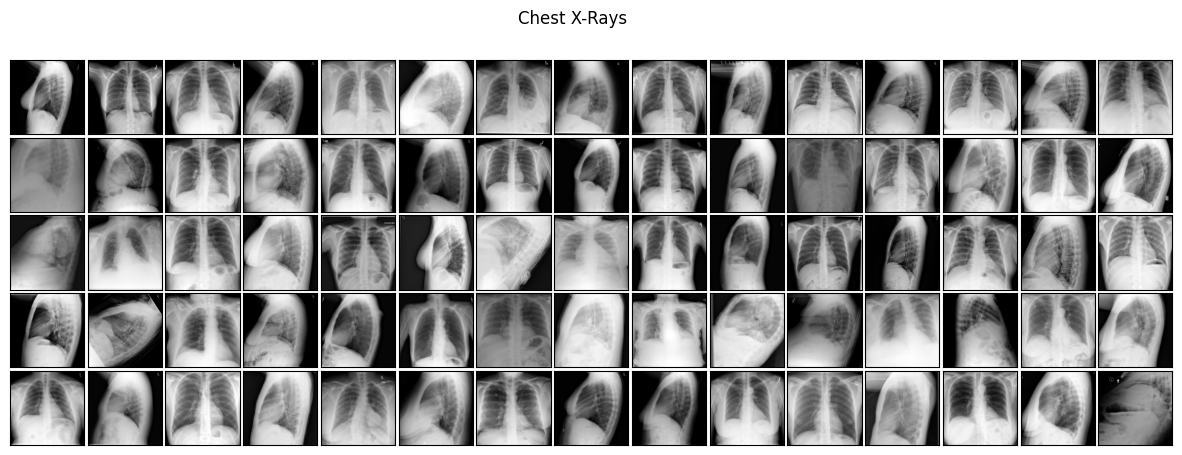

In [10]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

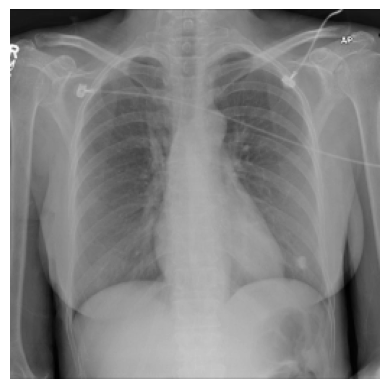

In [11]:
highlighted_sample = metadata.loc[metadata["image_name"] == "CXR21_IM-0729-1001-0001.png"]
highlighted_image = images[highlighted_sample.index]

plot_image(highlighted_image[0])

Time to plot a few random X-ray image and their corresponding reports!

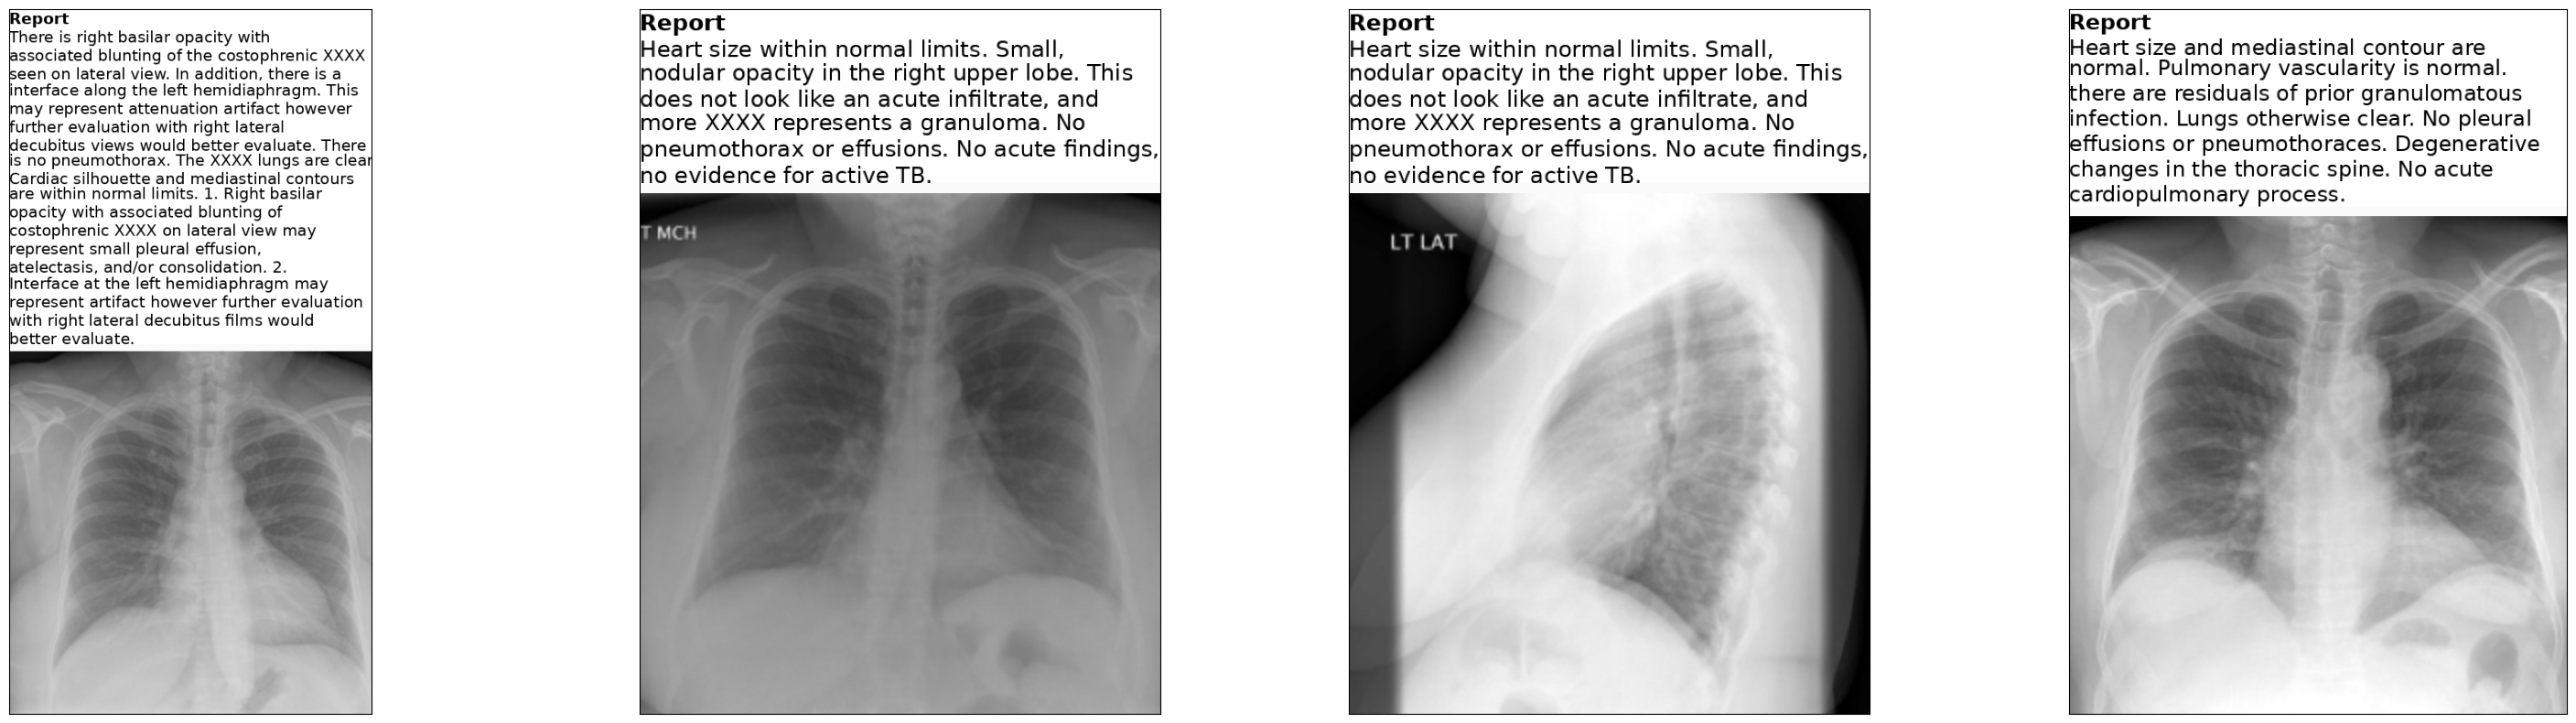

In [12]:
k = np.arange(4) + 1000 #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = np_images[k]

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

In [13]:
# references: https://arxiv.org/pdf/1711.08195v3.pdf, https://arxiv.org/pdf/2209.15323.pdf
# @TODO: embedding (pre-trained?)
# @TODO: attention (cross-attention) using tags
# @TODO: transformer model
# @TODO: compare against GPT-4 (with images) if possible

### Images

Let's, normalize the images to the range [0, 1].

In [14]:
images = images.type(torch.float32) / 255.

### Text

In [15]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

09:48:32 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


09:48:32 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

09:48:32 - INFO: Using device: cpu
09:48:32 - INFO: Loading: tokenize
09:48:32 - INFO: Done loading processors!


In [16]:
tokenized_reports.head()

0    [no, airspace, disease, effusion, or, noncalci...
1    [no, airspace, disease, effusion, or, noncalci...
2    [low, lung, volumes, cardiomediastinal, silhou...
3    [low, lung, volumes, cardiomediastinal, silhou...
4    [the, cardiomediastinal, silhouette, appears, ...
Name: report, dtype: object

In [17]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 37.4 +- 19.6 words.
Report length boundaries: [3.0; 226.0] words.


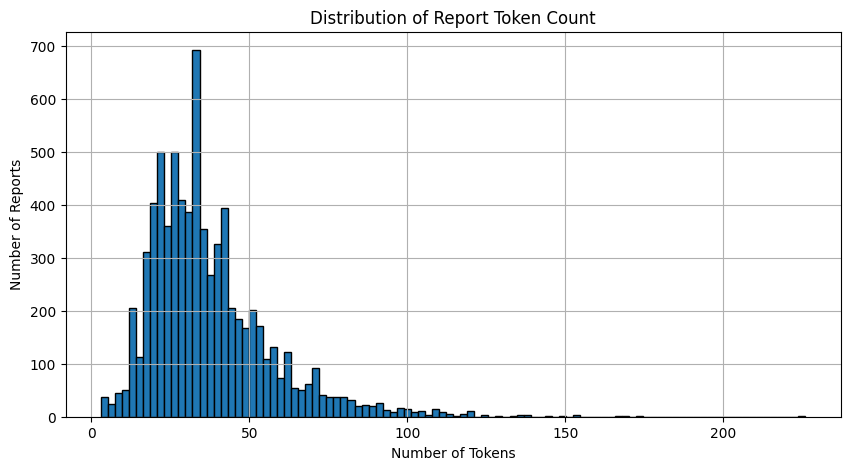

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Distribution of Report Token Count")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

In [ ]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

token2id, id2token = map_token_and_id_fn(vocabulary)

## Models

In [33]:
train_split = .9
train_size = int(len(images) * train_split)

train_dataset = XRayDataset(images[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images[train_size:], tokenized_reports[train_size:], token2id)

model_name = "base"
model = XRayBaseModel(len(vocabulary))

train(model_name, model, vocabulary, train_dataset, validation_dataset)

vocabulary size: 1933 tokens
Epoch 1 train loss: 4.241, validation loss: 4.169
Epoch 2 train loss: 3.239, validation loss: 3.608
Epoch 3 train loss: 2.858, validation loss: 3.392
Epoch 4 train loss: 2.705, validation loss: 3.313
Epoch 5 train loss: 2.677, validation loss: 3.273
Epoch 6 train loss: 2.519, validation loss: 3.251
Epoch 7 train loss: 2.544, validation loss: 3.253
Epoch 8 train loss: 2.495, validation loss: 3.248
Epoch 9 train loss: 2.382, validation loss: 3.245
Epoch 10 train loss: 2.390, validation loss: 3.238
Epoch 11 train loss: 2.321, validation loss: 3.245
Epoch 12 train loss: 2.246, validation loss: 3.256
Epoch 13 train loss: 2.185, validation loss: 3.268
Epoch 14 train loss: 2.217, validation loss: 3.275
Epoch 15 train loss: 2.160, validation loss: 3.286
Epoch 16 train loss: 2.139, validation loss: 3.304
Epoch 17 train loss: 2.093, validation loss: 3.320
Epoch 18 train loss: 2.087, validation loss: 3.327
Epoch 19 train loss: 2.019, validation loss: 3.342
Epoch 20 tr

In [34]:
result = load_dict(os.path.join("results", model_name, "result.pkl"))

train_losses = result["train_losses"]
validation_losses = result["validation_losses"]

perplexity = lambda loss: np.exp(loss)
print(f"perplexity | train: {perplexity(np.mean(train_losses))}, validation: {perplexity(np.mean(validation_losses))}, random: {perplexity(-np.log(1. / len(vocabulary)))}")

perplexity | train: 9.87942123413086, validation: 29.156003952026367, random: 1933.0


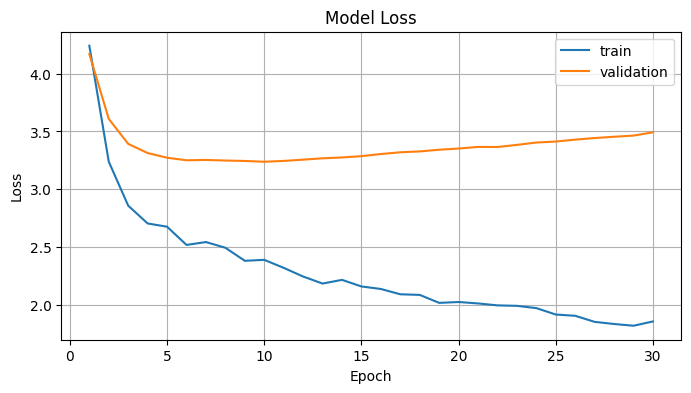

In [35]:
plot_losses(train_losses, validation_losses)

In [36]:
# Greedy, random sampling, etc
def generate_tokens(model, image, max_length=200):
    report = []

    with torch.no_grad():
        model.eval()

        text_start = torch.tensor(token2id("[START]"))[None,None]
        image = image[None]

        input = text_start
        context = model.encoder(image)

        for i in range(max_length):
            output, hidden = model.decoder(input, context)
            output = output[0]
            output = output.argmax(dim=-1)

            token = id2token(output.item())

            if token == "[END]":
                break

            report.append(token)
            
            input = output[None]
            context = hidden[0]

    return report

In [37]:
model = XRayBaseModel(len(vocabulary))
model.load_state_dict(torch.load(os.path.join("results", model_name, "model.pt"), map_location=torch.device("cpu")))

sample = train_dataset[0]

xray = sample[0]
report_ids = sample[1]

report_tokens = [id2token(token) for token in report_ids[1:-1]]
report_est_tokens = generate_tokens(model, xray)

report = " ".join(report_tokens)
report_est = " ".join(report_est_tokens)

print(f"true: {report}")
print(f"guess: {report_est}")

true: no airspace disease effusion or noncalcified nodule normal heart size and mediastinum left axillary surgical clips unchanged visualized xxxx of the chest xxxx are within normal limits no acute cardiopulmonary abnormality
guess: the heart size and pulmonary vasculature are clear no focal consolidation pleural effusion or pneumothorax no acute cardiopulmonary abnormality


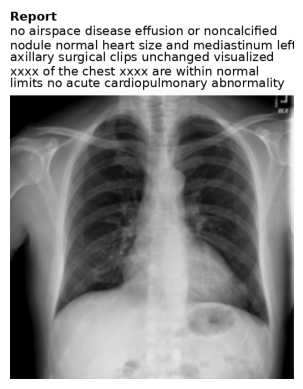

In [38]:
xray_plotable = (xray[0] * 255).numpy().astype(np.uint8)
plot_text_and_image(report, "Report", xray_plotable)